In [1]:
#Libraries Required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings(action='ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm 
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import mean_absolute_error
from IPython.display import display

In [2]:
# dataset path
file = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv'

# read the csv file into a pandas DataFrame
data = pd.read_csv(file)
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


<h3><b>Data Preprocessing</b></h3>

In [3]:
# drop the unwanted columns/features
cols_to_drop = ['No']
data = data.drop(cols_to_drop,axis=1)
# print out the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    43824 non-null  int64  
 1   month   43824 non-null  int64  
 2   day     43824 non-null  int64  
 3   hour    43824 non-null  int64  
 4   pm2.5   41757 non-null  float64
 5   DEWP    43824 non-null  int64  
 6   TEMP    43824 non-null  float64
 7   PRES    43824 non-null  float64
 8   cbwd    43824 non-null  object 
 9   Iws     43824 non-null  float64
 10  Is      43824 non-null  int64  
 11  Ir      43824 non-null  int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 4.0+ MB


In [4]:
# check for duplicate and null values
print('any duplicated values in data ? : {}\n'.format(data.duplicated().any()))
print('Total number of null values in each colum:')
display(data.isnull().sum())


any duplicated values in data ? : False

Total number of null values in each colum:


year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [5]:
# find the mode of  wind direction value
data.cbwd.mode()

0    SE
dtype: object

In [6]:
# fill in the missing values with the mean of the particular column
data.fillna(value=data.mean(),inplace=True)

# replace the missing values in wind direction with the modal value
data.cbwd.fillna(value='NE',inplace=True)

# Checking the data again for any missing values
data.isnull().any()

year     False
month    False
day      False
hour     False
pm2.5    False
DEWP     False
TEMP     False
PRES     False
cbwd     False
Iws      False
Is       False
Ir       False
dtype: bool

In [7]:
# create a datetime column
years = data['year'].values
months = data['month'].values
days = data['day'].values
hours = data['hour'].values
full_date = []

for i in range(data.shape[0]):
    date_time = str(years[i])+'-'+str(months[i])+'-'+str(days[i])+' '+str(hours[i])+':'+str(0)
    full_date.append(date_time)

dates = pd.to_datetime(full_date)
dates = pd.DataFrame(dates,columns=['date'])
data = pd.concat([dates,data],axis=1)

data.head()

,date,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2010-01-01 00:00:00,2010,1,1,0,98.613215,-21,-11.0,1021.0,NW,1.79,0,0
1,2010-01-01 01:00:00,2010,1,1,1,98.613215,-21,-12.0,1020.0,NW,4.92,0,0
2,2010-01-01 02:00:00,2010,1,1,2,98.613215,-21,-11.0,1019.0,NW,6.71,0,0
3,2010-01-01 03:00:00,2010,1,1,3,98.613215,-21,-14.0,1019.0,NW,9.84,0,0
4,2010-01-01 04:00:00,2010,1,1,4,98.613215,-20,-12.0,1018.0,NW,12.97,0,0


<h3><b>Exploratory Data Analysis (EDA)</b></h3>
<p> Performing EDA to gain insights from the data. 
   eg
    <ul>
    <li>what pattern does the amount of PM2.5 concentration in the air recorded in an hour follow
        for a daily time period ?</li>
    <li>In which month does the amount of PM2.5 contained in the air rises ?</li>
    <li>At what time of the day do we expect the amount of PM2.5 concentration in the
        air to be high ?</li>
    <li>In which direction does polluted air mostly move ?</li>
    <li>How do the other environmental factors affect the amount of PM2.5 concentration
        in the air ?</li>
</ul>.</p>

In [8]:
data.shape

(43824, 13)

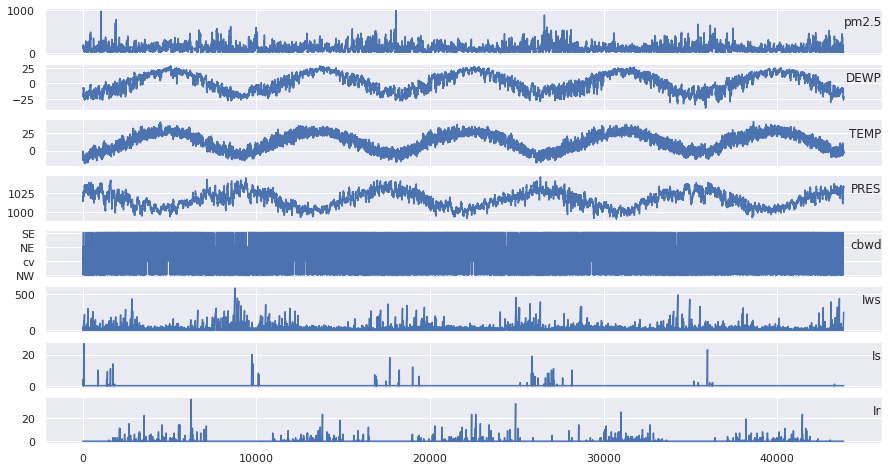

In [9]:
#Lets first check each feature values

values = data.iloc[:,5:].values
groups = [0, 1, 2, 3, 4, 5,6,7]
i = 1
plt.figure(figsize=(15,8))
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.iloc[:,5:].columns[group], y=0.5, loc='right')
    i += 1


plt.show()

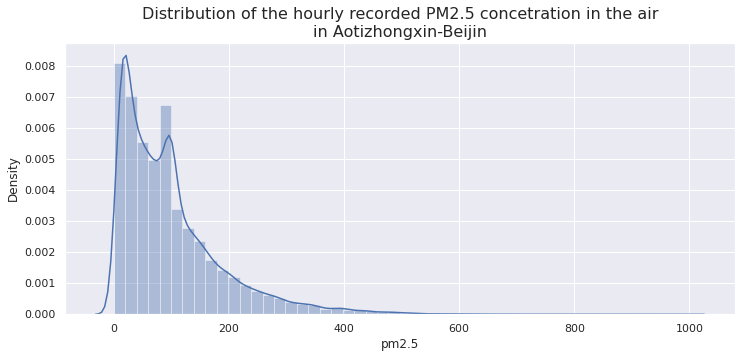

In [10]:
plt.figure(figsize=(12,5))
sns.distplot(data['pm2.5'],bins=50)
plt.title('Distribution of the hourly recorded PM2.5 concetration in the air\nin Aotizhongxin-Beijin',
          fontsize=16)
plt.show()

<h5><b>what pattern does the amount of PM2.5 concentration in the air recorded in an hour follow
        for a daily time period ?</b></h5>

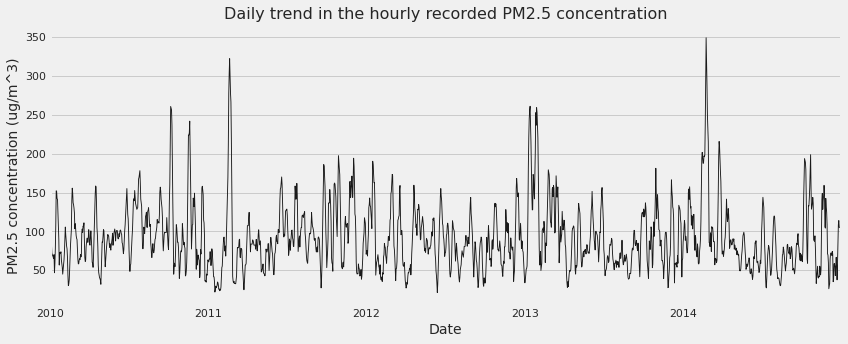

In [11]:
# find the daily average of PM2.5 contained in the air in any given hour
daily_data = data[['date','pm2.5']]
daily_data = daily_data.set_index('date')
daily_data = daily_data.resample('D').median()
decomposition = seasonal_decompose(daily_data,model='addictive')

# plot the data
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(12,5),style='k-',linewidth=.9,legend=False)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Daily trend in the hourly recorded PM2.5 concentration',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

<h5><b>In which month does the amount of PM2.5 contained in the air rises ?</b></h5>

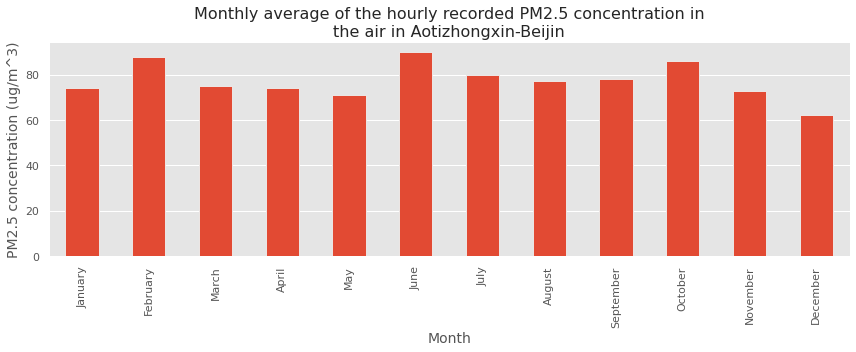

In [12]:
monthly_data = data[['month','pm2.5']]
months = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
ordered_monthdf = pd.DataFrame(months,columns=['month'])
map_dict = {}
for i,j in enumerate(months):
    map_dict.setdefault(i+1,j)

monthly_data.month = monthly_data.month.map(map_dict)
monthly_average = monthly_data.groupby('month').median()
monthly_average = pd.merge(ordered_monthdf,monthly_average,left_on='month',right_index=True)
monthly_average = np.round(monthly_average,1)
monthly_average = monthly_average.set_index('month')

# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM2.5 concentration in\nthe air in Aotizhongxin-Beijin',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

<h5><b>At what time of the day do we expect the amount of PM2.5 concentration in the air to be high ?</b></h5>

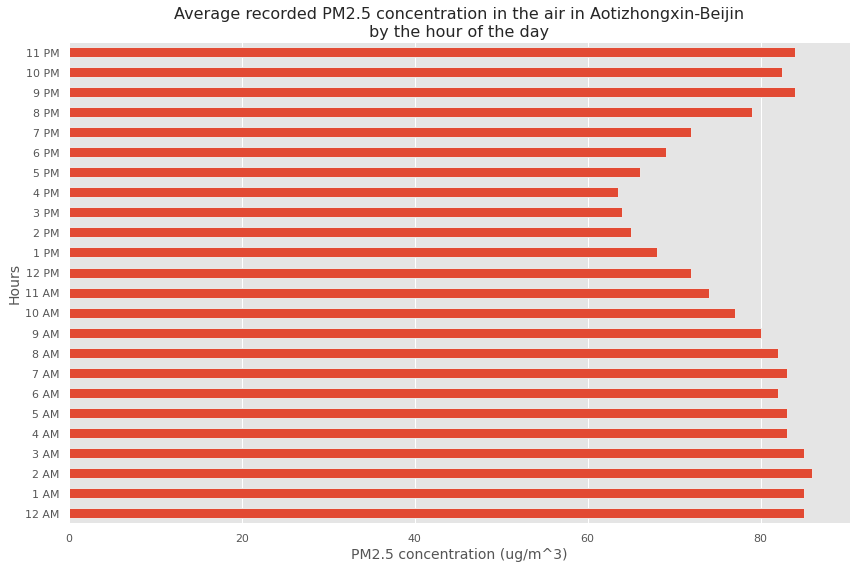

In [13]:
hourly_data = data[['hour','pm2.5']]
hrs = ['12 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM',
      '11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
      '8 PM','9 PM','10 PM','11 PM']
hour_dict = {}
for i,j in enumerate(hrs):
    hour_dict.setdefault(i,j)
    
hourly_data = hourly_data.groupby('hour').median().reset_index()
hourly_data.hour = hourly_data.hour.map(hour_dict)
hourly_data = hourly_data.set_index('hour')

# plot the data
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(12,8),legend=False,kind='barh',linewidth=.9)
    plt.ylabel('Hours',fontsize=14)
    plt.xlabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Average recorded PM2.5 concentration in the air in Aotizhongxin-Beijin\nby the hour of the day',fontsize=16)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

<h5><b>In which direction does polluted air/wind mostly move ?</b></h5>

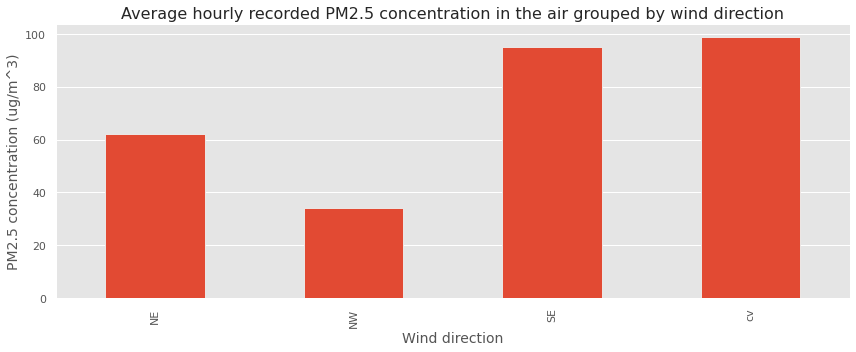

In [14]:
wind_dir = data[['cbwd','pm2.5']]
wind_dir = wind_dir.groupby('cbwd').median()

# plot the data
with plt.style.context('ggplot'):
    wind_dir.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Wind direction',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Average hourly recorded PM2.5 concentration in the air grouped by wind direction',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

<h5><b>How do the other environmental factors affect the amount of PM2.5 concentration in the air ?</b></h5>

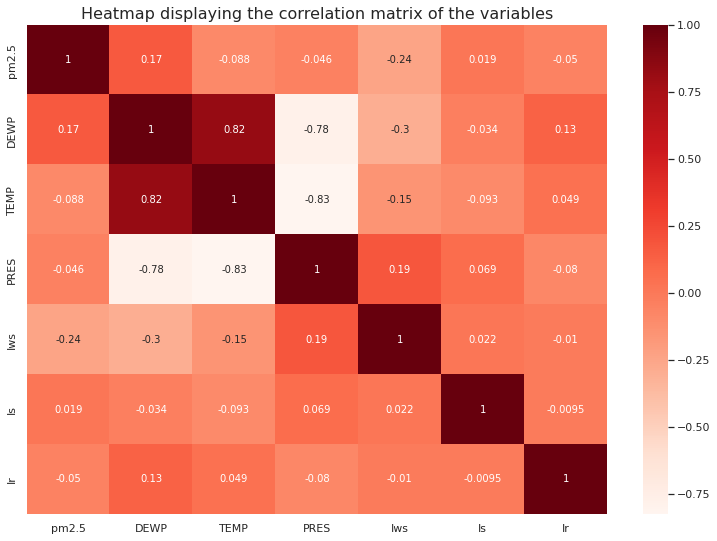

In [15]:
# let's try and visualize the relationships between the features of the data
plt.figure(figsize=(13,9))
correlation_data = data[['pm2.5','DEWP', 'TEMP', 'PRES',
                         'Iws', 'Is', 'Ir']]

sns.heatmap(correlation_data.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16)
plt.show()

<h1><b>Model Training and Evaluation</b></h1>

In [16]:
cols_to_drop = ['date','year','month','day','hour','cbwd']



newdata = data.drop(cols_to_drop,axis=1)

newdata['pm2.5'] = np.log(newdata['pm2.5'])
newdata

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
0,4.591205,-21,-11.0,1021.0,1.79,0,0
1,4.591205,-21,-12.0,1020.0,4.92,0,0
2,4.591205,-21,-11.0,1019.0,6.71,0,0
3,4.591205,-21,-14.0,1019.0,9.84,0,0
4,4.591205,-20,-12.0,1018.0,12.97,0,0
...,...,...,...,...,...,...,...
43819,2.079442,-23,-2.0,1034.0,231.97,0,0
43820,2.302585,-22,-3.0,1034.0,237.78,0,0
43821,2.302585,-22,-3.0,1034.0,242.70,0,0
43822,2.079442,-22,-4.0,1034.0,246.72,0,0


In [17]:
# we split the data into predictor variables and Outcome variable
X = newdata.drop('pm2.5',axis=1)
y = newdata['pm2.5']

# le = preprocessing.LabelEncoder()
# le.fit(X["cbwd"])

# X["cbwd"] = le.transform(X["cbwd"])


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.dropna(inplace=True)
# print the scaled values
X_scaled.head()

,DEWP,TEMP,PRES,Iws,Is,Ir
0,0.279412,0.131148,0.545455,0.002290,0.0,0.0
1,0.279412,0.114754,0.527273,0.007639,0.0,0.0
2,0.279412,0.131148,0.509091,0.010698,0.0,0.0
3,0.279412,0.081967,0.509091,0.016047,0.0,0.0
4,0.294118,0.114754,0.490909,0.021396,0.0,0.0


# learning curve method

In [18]:
train_sizes = [1, 1000, 500, 5000, 20000, 31552]
### Bundling our previous work into a function ###
def learning_curves(estimator, features, target, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, features, target, train_sizes = train_sizes, cv = cv, scoring = 'neg_mean_squared_error')
    
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,10000)


<br>
<h2><b>Ensemble methods</b></h2>
<p>For ensemble methods (DecisionTreeRegressor,RandomForestRegressor,and GradientBoostingRegressor).</p>

In [19]:
ensemble_data = data.drop(cols_to_drop,axis=1)

# we split the data into predictor variables and Outcome variable
X = ensemble_data.drop('pm2.5',axis=1)
y = ensemble_data['pm2.5']

In [20]:
xtrain,xtest,ytrain,ytest = train_test_split(X_scaled,y,test_size=.1, shuffle = True, random_state = 11)

### DecisionTreeRegressor MODEL
we will now fit a decision tree regression model on the data and tune some of its parameters to increase the accuracy.

In [21]:
# we go ahead to use the ensemble methods as the LinearRegression model has a low accuracy
# on both the test and train data.
decision_tree = DecisionTreeRegressor(max_depth=23,
                                     max_features='auto',
                                     min_samples_split=10,
                                     min_samples_leaf=21)
decision_tree.fit(xtrain,ytrain)

DecisionTreeRegressor(max_depth=23, max_features='auto', min_samples_leaf=21,
                      min_samples_split=10)

In [22]:
tree_pred = decision_tree.predict(xtest)
tree_mse = mean_squared_error(ytest,tree_pred)
tree_mae = mean_absolute_error(ytest,tree_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_mse)))
print('MAE: {}\n'.format(tree_mae))


Root Mean Squared Error: 72.0308564774801

MAE: 50.16774802153664



### Hyperparamters Tuning

In [23]:
# We now tune the parameters of the model to see if we can increase the accuracy
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
params = {'max_depth':[1,5,9,15,20],
         'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4,5,6],
         'min_samples_leaf':[2,3,4,6,7]}

tree = DecisionTreeRegressor()

# initialize the grid search for the best parameters
tree_search = GridSearchCV(tree,param_grid=params,
                          n_jobs=-1,cv=5)

tree_search.fit(xtrain,ytrain)   # fit the model

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 9, 15, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 6, 7],
                         'min_samples_split': [2, 3, 4, 5, 6]})

In [24]:
print('Best parameters found:')
display(tree_search.best_params_)

tree_search_pred = tree_search.predict(xtest)
tree_search_mse = mean_squared_error(ytest,tree_search_pred)
tree_search_mae = mean_absolute_error(ytest, tree_search_pred)
print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_search_mse)))
print('MAE: {}\n'.format(tree_search_mae))


Best parameters found:


{'max_depth': 9,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5}

Root Mean Squared Error: 73.22451814310206

MAE: 51.0976523047507



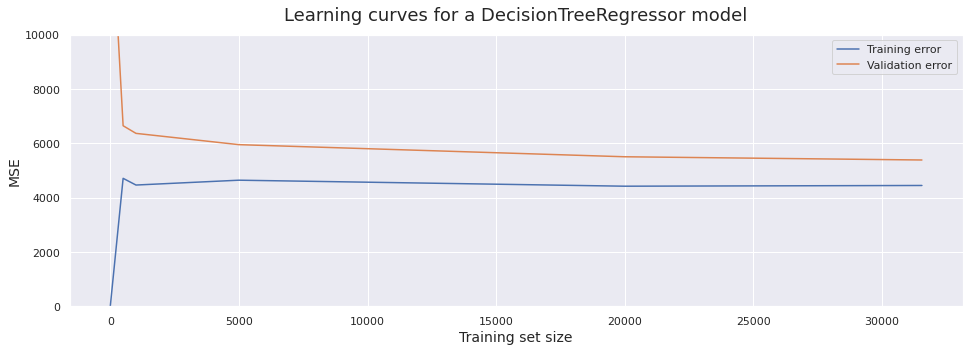

In [26]:
#learning curve
from sklearn.model_selection import learning_curve


plt.figure(figsize = (16,5))
learning_curves(decision_tree, xtrain, ytrain, train_sizes, 5)

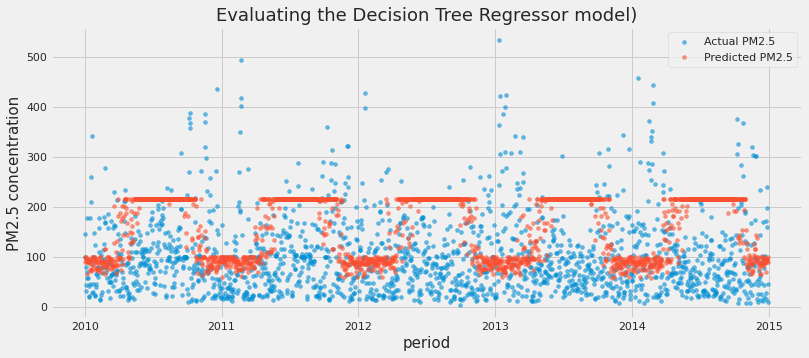

In [27]:
# (DecisionRegressor model) to predict the PM2.5 
# visualization

compare_data = pd.DataFrame({'dates':data['date'],
                            'Actual PM2.5':y,
                            'Predicted PM2.5':tree_search.predict(X.values)})

compare_data.set_index('dates',inplace=True)
compare_data['Predicted PM2.5'] = np.round(compare_data['Predicted PM2.5'],1)

# let's plot the daily averages of the Actual PM10 and the predicted PM2.5 concentration.
compare_data = compare_data.resample('D').mean()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data['Actual PM2.5'],s=15,label='Actual PM2.5',
               alpha=.6)
    plt.scatter(compare_data.index,compare_data['Predicted PM2.5'],s=15,label='Predicted PM2.5',
               alpha=.6)
    plt.legend()
    plt.title('Evaluating the Decision Tree Regressor model)',
             fontsize=18)
    plt.xlabel('period',fontsize=15)
    plt.ylabel('PM2.5 concentration',fontsize=15)
    plt.show()

### RandomForestRegressor MODEL

we now fit a random forest regression model on the data to see if we would get a better accuracy results than that of the decision tree regression model.

In [28]:
#RandomForestRegressor model and fit the model on the training data
forest = RandomForestRegressor(n_estimators=800,
                              max_depth=25,
                              max_features='auto',
                              min_samples_split=2,
                              min_samples_leaf=2)

forest.fit(xtrain,ytrain)

RandomForestRegressor(max_depth=25, min_samples_leaf=2, n_estimators=800)

In [29]:
forest_pred = forest.predict(xtest)
forest_mse = mean_squared_error(ytest,forest_pred)
forest_mae = mean_absolute_error(ytest,forest_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_mse)))
print('MAE: {}\n'.format(forest_mae))

Root Mean Squared Error: 69.30285168195486

MAE: 47.111369493021606



### Hyperparamters Tuning

In [30]:
# we now tune the parameters of the RandomForestRegressor model

params['n_estimators'] = [100,200,300,400,500]

# instantiate the model
random_forest = RandomForestRegressor()

# perform the grid search for the best parameters
forest_search = RandomizedSearchCV(random_forest,params,n_jobs=-1,
                                   cv=5,verbose=2)
forest_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 5, 9, 15, 20],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 6, 7],
                                        'min_samples_split': [2, 3, 4, 5, 6],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [31]:

print('Best parameters found:')
display(forest_search.best_params_)

forest_search_pred = forest_search.predict(xtest)
forest_search_mse = mean_squared_error(ytest,forest_search_pred)
forest_search_mae = mean_absolute_error(ytest, forest_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_search_mse)))
print('MAE: {}\n'.format(forest_search_mae))


Best parameters found:


{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 300}

Root Mean Squared Error: 68.15114343091665

MAE: 47.528731812018464



In [32]:
#learning curve
plt.figure(figsize = (16,5))
learning_curves(forest, xtrain, ytrain, train_sizes, 5)

KeyboardInterrupt: ignored

<Figure size 1152x360 with 0 Axes>

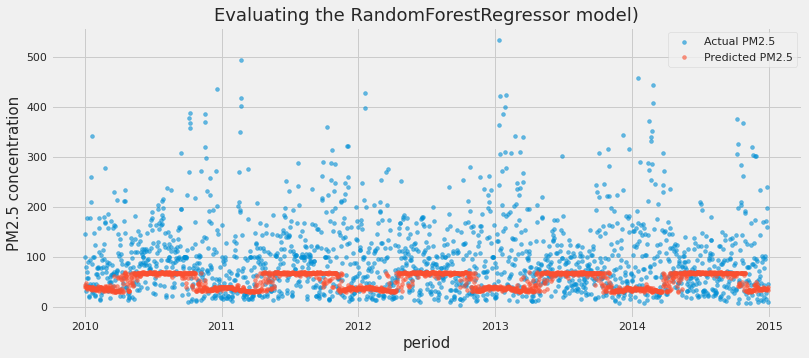

In [33]:
# (RandomForestRegressor model) to predict the PM2.5 
# visualization

compare_data = pd.DataFrame({'dates':data['date'],
                            'Actual PM2.5':y,
                            'Predicted PM2.5':forest_search.predict(X.values)})

compare_data.set_index('dates',inplace=True)
compare_data['Predicted PM2.5'] = np.round(compare_data['Predicted PM2.5'],1)

# let's plot the daily averages of the Actual PM10 and the predicted PM2.5 concentration.
compare_data = compare_data.resample('D').mean()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data['Actual PM2.5'],s=15,label='Actual PM2.5',
               alpha=.6)
    plt.scatter(compare_data.index,compare_data['Predicted PM2.5'],s=15,label='Predicted PM2.5',
               alpha=.6)
    plt.legend()
    plt.title('Evaluating the RandomForestRegressor model)',
             fontsize=18)
    plt.xlabel('period',fontsize=15)
    plt.ylabel('PM2.5 concentration',fontsize=15)
    plt.show()

### GradientBoostingRegressor MODEL

we now fit a gradient boosting regression model on the data to see if we would get a better accuracy results than that of the decision tree and random forest regression model and also minimize the error.

In [34]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=400,
                                      max_depth=9,
                                      max_features='auto',
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.5)

grad_boost.fit(xtrain,ytrain)


GradientBoostingRegressor(learning_rate=0.5, max_depth=9, max_features='auto',
                          min_samples_leaf=3, min_samples_split=7,
                          n_estimators=400)

In [35]:
gboost_pred = grad_boost.predict(xtest)
gboost_mse = mean_squared_error(ytest,gboost_pred)
gboost_mae = mean_absolute_error(ytest,gboost_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_mse)))
print('MAE: {}\n'.format(gboost_mae))

Root Mean Squared Error: 77.9789140741761

MAE: 53.96287986046217



### Hyperparameters Tuning

In [ ]:
# we now tune the parameters of the GradientBoostingRegressor model
params['learning_rate'] = np.linspace(0.1,1,10)

# instantiate the model
gradient_boosting = GradientBoostingRegressor()

# perform the grid search for the best parameters
gboost_search = RandomizedSearchCV(gradient_boosting,params,n_jobs=-1,
                                   cv=5,verbose=2)
gboost_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
print('Best parameters found:')
display(gboost_search.best_params_)

gboost_search_pred = gboost_search.predict(xtest)
gboost_search_mse = mean_squared_error(ytest,gboost_search_pred)
gboost_search_mae = mean_absolute_error(ytest,gboost_search_pred)



print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_search_mse)))
print('MAE {}\n'.format(gboost_search_mae))


In [ ]:
#learning curve
plt.figure(figsize = (16,10))
learning_curves(grad_boost, xtrain, ytrain, train_sizes, 5)

In [ ]:
#  (GradientBoostingRegressor model) to predict the PM2.5 
# visualization

compare_data = pd.DataFrame({'dates':data['date'],
                            'Actual PM2.5':y,
                            'Predicted PM2.5':gboost_search.predict(X.values)})

compare_data.set_index('dates',inplace=True)
compare_data['Predicted PM2.5'] = np.round(compare_data['Predicted PM2.5'],1)

# let's plot the daily averages of the Actual PM10 and the predicted PM2.5 concentration.
compare_data = compare_data.resample('D').mean()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data['Actual PM2.5'],s=15,label='Actual PM2.5',
               alpha=.6)
    plt.scatter(compare_data.index,compare_data['Predicted PM2.5'],s=15,label='Predicted PM2.5',
               alpha=.6)
    plt.legend()
    plt.title('Evaluating the GradientBoostingRegressor model)',
             fontsize=18)
    plt.xlabel('period',fontsize=15)
    plt.ylabel('PM2.5 concentration',fontsize=15)
    plt.show()

In [ ]:
# calculate the errors
compare_data['Residuals'] = compare_data['Actual PM2.5'] - compare_data['Predicted PM2.5']

# plot the histogram to see check the normality of the errors
plt.figure(figsize=(12,5))
sns.distplot(compare_data.Residuals,bins=50)
plt.title('Distribution of the residuals from the gradient boosting model',
         fontsize=16)
plt.show()

# SVM MODEL

In [ ]:
# we now split out data into train and test data (80 percent training, 20 percent testing)
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.20,random_state=0)

In [ ]:
# instantiate the SVM model
reg = svm.SVR(C=0.3)
reg.fit(X_train, y_train)  # fit the model

In [ ]:
prediction = reg.predict(X_test)
mse = mean_squared_error(y_test,prediction)
mae = mean_absolute_error(y_test,prediction)

print('Root Mean Squared Error (RMSE): {}\n'.format(np.sqrt(mse)))
print('MAE: {}\n'.format(mae))

### Hyper parameters Tuning

In [ ]:
# we now tune the parameters of the SVM

reg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1],
                               "gamma": np.logspace(-2, 2, 4)})
reg.fit(X_train, y_train)


In [ ]:
prediction = reg.predict(X_test)

display(reg.best_params_)

mse = mean_squared_error(y_test,prediction)
mae = mean_absolute_error(y_test,prediction)

print('Root Mean Squared Error (RMSE): {}\n'.format(np.sqrt(mse)))
print('MAE: {}\n'.format(mae))

In [ ]:
#learning curve
plt.figure(figsize = (16,5))
learning_curves(reg, xtrain, ytrain, train_sizes, 5)

In [ ]:
# (SVM model) to predict the PM2.5 
# visualization

compare_data = pd.DataFrame({'dates':data['date'],
                            'Actual PM2.5':y,
                            'Predicted PM2.5':reg.predict(X.values)})

compare_data.set_index('dates',inplace=True)
compare_data['Predicted PM2.5'] = np.round(compare_data['Predicted PM2.5'],1)

# let's plot the daily averages of the Actual PM10 and the predicted PM2.5 concentration.
compare_data = compare_data.resample('D').mean()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data['Actual PM2.5'],s=15,label='Actual PM2.5',
               alpha=.6)
    plt.scatter(compare_data.index,compare_data['Predicted PM2.5'],s=15,label='Predicted PM2.5',
               alpha=.6)
    plt.legend()
    plt.title('Evaluating the SVM model)',
             fontsize=18)
    plt.xlabel('period',fontsize=15)
    plt.ylabel('PM2.5 concentration',fontsize=15)
    plt.show()

# ARIMA MODEL 

optional (take time to train)

In [ ]:
# ARIMA
from tqdm import tqdm
from statsmodels.tsa.arima_model import ARIMA
split_date = '2014-05-01'
df_training = data.loc[data.date <= split_date]

df_test = data.loc[data.date > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
tep = df_test['pm2.5']
for t in tqdm(range(len(tep))):
    temp_train = data[:len(df_training)+t]
    model = ARIMA(temp_train['pm2.5'], order=(1, 0, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

In [ ]:
org = df_test['pm2.5']

arima_mse = mean_squared_error(org,yhat)
arima_mae = mean_absolute_error(org,yhat)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(arima_mse)))
print('MAE: {}\n'.format(arima_mae))